<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

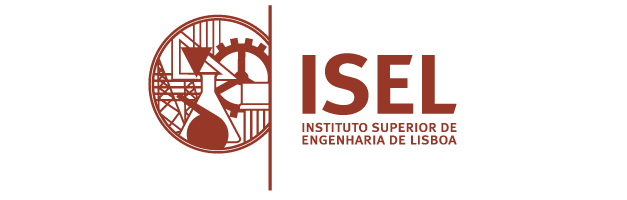

Estudo organizado em 3 notebooks:
*   [O anterior](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Fotografia.ipynb) - Fotografia do ISEL hoje (assimetrias) 
*   Este notebook - Olhar para o Futuro (dinâmica de aposentações)
*   [O próximo e último](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Converge.ipynb) - Convergência (correção das assimetrias)

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

     |████████████████████████████████| 57 kB 804 kB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 79.9 MB 102 kB/s 


In [2]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import widgets, interact, fixed
from IPython.display import Image

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [4]:
# Designações dos cursos e departamentos
LISTA_DEPTS = sorted(docentes['Departamento'].unique())
LISTA_CURSOS = sorted(alunos_per_curso.index.unique())

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

In [6]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_curso = horas.sum(axis=1)
pesos_dept_per_curso = horas.T / horas_per_curso

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

## Definição de funções

In [7]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [8]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].sum()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

# Olhar para o Futuro

In [9]:
ANOS = 10
LST_ANOS = range(2022, 2022+ANOS+1)

## Evolução do Número de Alunos

**Hipótese:** Vai-se manter tudo igual 

Será assim?

Quais as áreas onde se prevê acréscimo de procura?

Criação de Departamento de Informática?

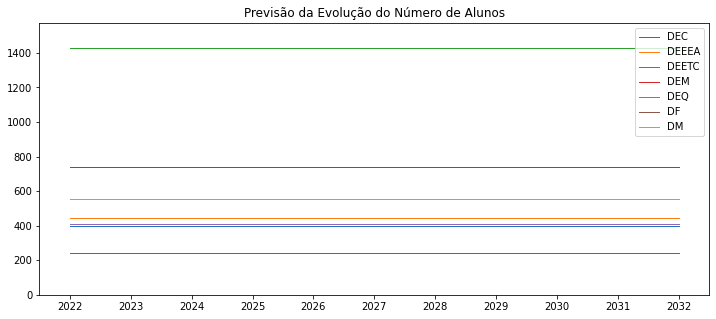

In [42]:
# Evolução do número de alunos
df = pd.DataFrame([alunos_per_dept.values for ano in LST_ANOS], 
                  columns=alunos_per_dept.index, index=LST_ANOS)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
df.plot(ax=ax, linewidth=1)
ax.set_xticks(LST_ANOS)
ax.set_ylim(ymin=0, ymax=alunos_per_dept.max()*1.1)
ax.set_title('Previsão da Evolução do Número de Alunos');

## Evolução dos recursos docentes (dinâmica de aposentações)

In [12]:
IDADE_REFORMA = 70

In [43]:
# Desenho de gráfico com todas as referências a 100% no primeiro ano
def plot_ref_one(df, title='', size=(12,5)):
  percentage = df/df.iloc[0]
  fig, ax = plt.subplots(1, 1, figsize=size)
  percentage.plot(ax=ax, linewidth=3)
  ax.set_title(title)
  ax.set_ylim(ymin=0, ymax=1.4)
  ax.set_xlim(xmin=0, xmax=ANOS)
  ax.grid(True)
  fig.savefig('temp_image.png')

In [44]:
def time_evolution_ratio(lst_anos, categoria):
  df = pd.DataFrame([docentes_per_categoria(docentes, categoria)], 
                    index=[str(lst_anos[0])], columns=LISTA_DEPTS)
  df2 = pd.DataFrame([docentes_per_categoria(docentes, cat_todas)], 
                    index=[str(lst_anos[0])], columns=LISTA_DEPTS)
  for ano in lst_anos[1:]:
    ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
    s = docentes_per_categoria(at, categoria)
    s.name = str(ano)
    df = df.append(s)

    s = docentes_per_categoria(at, cat_todas)
    s.name = str(ano)
    df2 = df2.append(s)
  return df/df2

In [46]:
# Dataframe com a evolução temporal relativa de recursos docentes por departamento
def time_evolution_eti(categoria, lst_anos, plot=False):
  df = pd.DataFrame([docentes_per_categoria(docentes, categoria)], 
                    index=[str(lst_anos[0])], columns=LISTA_DEPTS)
  for ano in lst_anos[1:]:
    ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
    s = docentes_per_categoria(at, categoria)
    s.name = str(ano)
    df = df.append(s)
  if plot:
    plot_ref_one(df, f'Ritmo de aposentações na categoria de {inv_catgs[tuple(categoria)]}')
  else:
    return df

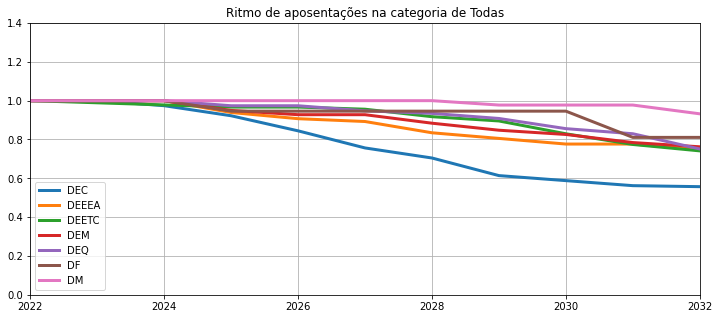

In [48]:
# Evolução relativo dos ETIs
time_evolution_eti(cat_todas, LST_ANOS, plot=True)

In [49]:
# Ritmo de aposentações na categoria (interativo)
catgs = {'Coordenadores':cat_prof_coord, 
         'Adjuntos': cat_adjunto,
         'Quadro': cat_quadro,
         'Convidados': cat_convidado,
         'Todas': cat_todas}
inv_catgs = {tuple(v): k for k, v in catgs.items()}
interact(time_evolution_eti, lst_anos=fixed(LST_ANOS), plot=fixed(True), 
         categoria=widgets.Dropdown(options=catgs, value=cat_prof_coord));

interactive(children=(Dropdown(description='categoria', options={'Coordenadores': ['Prof. Coordenador', 'Prof.…

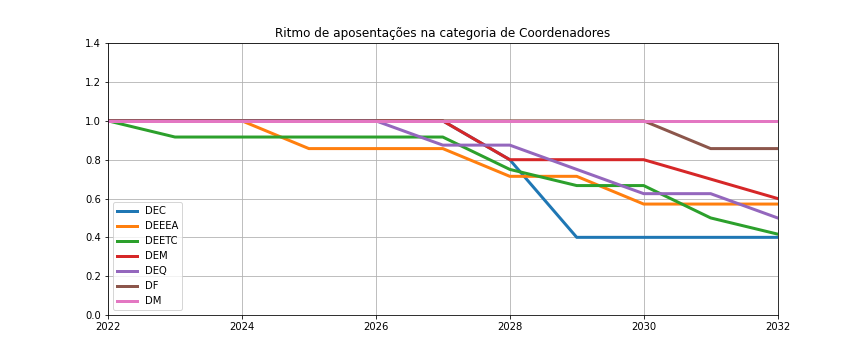

In [50]:
# Figura estática
Image('temp_image.png')

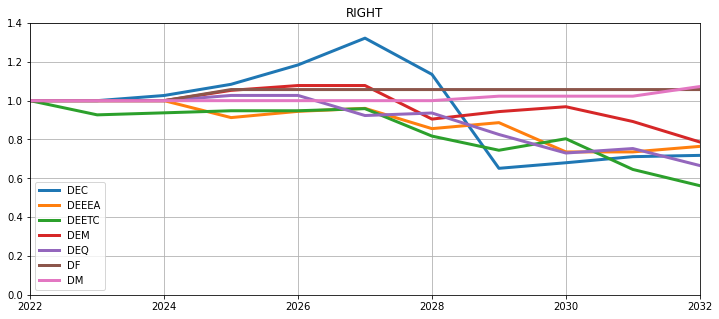

In [51]:
df1 = time_evolution_eti(cat_prof_coord, LST_ANOS)
df2 = time_evolution_eti(cat_todas, LST_ANOS)
df3 = df1/df2
plot_ref_one(df3, title='RIGHT')